# Aadhaar Insight: A Decision-Support System for UIDAI

## Problem Statement and Approach
**Problem Statement:** Unlocking Societal Trends in Aadhaar Enrolment and Updates.
The goal is to transform raw enrolment and update logs into a **Decision Support System (DSS)** for UIDAI. This system identifies meaningful patterns, demographic shifts, and operational anomalies to support informed policy-making and resource allocation.

**Approach:**
We adopt a multi-layered analytical approach:
1.  **Demographic Profiling:** Understanding the age-wise distribution of new enrolments.
2.  **Geospatial Mapping:** Identifying high-activity regions for targeted infrastructure planning.
3.  **Temporal Trending:** Monitoring monthly fluctuations to predict peak demand periods.
4.  **Operational Auditing:** Detecting anomalies in Pincode-level activity to flag potential fraud or data errors.


In [2]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Datasets Used
We utilize the official datasets provided for the Hackathon:

1.  **Aadhaar Enrolment Dataset:**
    *   Columns: `date`, `state`, `district`, `pincode`, `age_0_5`, `age_5_17`, `age_18_greater`
    *   Purpose: Analysis of new Aadhaar generation across age cohorts and locations.

2.  **Aadhaar Demographic Update Dataset:**
    *   Columns: `date`, `state`, `district`, `pincode`, `demo_age_5_17`, `demo_age_17_`
    *   Purpose: Tracking corrections and updates in demographic details (Name, Address, etc.).

3.  **Aadhaar Biometric Update Dataset:**
    *   Columns: `date`, `state`, `district`, `pincode`, `bio_age_5_17`, `bio_age_17_`
    *   Purpose: Monitoring mandatory biometric updates (MBU) and voluntary updates.


## Methodology
The methodology involves a systematic pipeline of Data Loading, Integration, and Preprocessing.

### Data Loading and Integration
The raw data is fragmented into multiple CSV chunks within the `biometric`, `demographic`, and `enrolment` directories. We use an automated script to:
*   Traverse the directory structure.
*   Read individual CSV files.
*   Concatenate them into three master DataFrames: `biometric_df`, `demographic_df`, and `enrolment_df`.


In [3]:
# Define base path
base_path = 'd:/Aadhar Data/DATA'

# Function to load and concatenate CSVs from a folder
def load_data(folder_name):
    path = os.path.join(base_path, folder_name, "*.csv")
    files = glob.glob(path)
    if not files:
        print(f"No files found in {folder_name}")
        return pd.DataFrame()
    
    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {f}: {e}")
    
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    return pd.DataFrame()

# Load datasets
print("Loading Biometric Data...")
biometric_df = load_data('biometric')
print("Loading Demographic Data...")
demographic_df = load_data('demographic')
print("Loading Enrolment Data...")
enrolment_df = load_data('enrolment')

print(f"Biometric Data Shape: {biometric_df.shape}")
print(f"Demographic Data Shape: {demographic_df.shape}")
print(f"Enrolment Data Shape: {enrolment_df.shape}")


Loading Biometric Data...
No files found in biometric
Loading Demographic Data...
No files found in demographic
Loading Enrolment Data...
No files found in enrolment
Biometric Data Shape: (0, 0)
Demographic Data Shape: (0, 0)
Enrolment Data Shape: (0, 0)


### Data Cleaning and Preprocessing
To ensure analytical rigour, we apply the following transformations:
*   **Temporal Standardization:** The `date` column is converted to datetime objects to enable time-series resampling.
*   **Geographical Normalization:** `state` and `district` names are stripped of whitespace and title-cased to prevent duplicate categories due to formatting inconsistencies.
*   **Data Validation:** We verify the integrity of the data structure and check for missing values.


In [4]:
# Function to clean dataframe
def clean_df(df):
    if df.empty:
        return df
    
    # Convert date
    # Format appears to be DD-MM-YYYY based on sample '31-12-2025'
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
    
    # Standardize State and District
    if 'state' in df.columns:
        df['state'] = df['state'].str.strip().str.title()
    if 'district' in df.columns:
        df['district'] = df['district'].str.strip().str.title()
        
    return df

print("Cleaning Data...")
biometric_df = clean_df(biometric_df)
demographic_df = clean_df(demographic_df)
enrolment_df = clean_df(enrolment_df)

# Check info
print("Enrolment Info:")
print(enrolment_df.info())


Cleaning Data...
Enrolment Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame
None


## Data Analysis and Visualisation
We present key insights derived from the data, organized by analytical theme.

### General Enrolment Demographics
We begin by analyzing the overall composition of Aadhaar enrolments.


In [5]:
if not enrolment_df.empty:
    # Summarize age groups
    age_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
    age_sums = enrolment_df[age_cols].sum()
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x=age_sums.index, y=age_sums.values, palette='viridis')
    plt.title('Total Enrolments by Age Group')
    plt.ylabel('Count')
    plt.show()
    
    print("Total Enrolments by Age Group:")
    print(age_sums)


### Child-centric Aadhaar Activity
A dedicated analysis of child enrolments (0-5 and 5-17 years), which is critical for the "Bal Aadhaar" initiative and school-age coverage.


In [6]:
if not enrolment_df.empty:
    # Child specific columns
    child_cols = ['age_0_5', 'age_5_17']
    
    # Yearly trend for children (assuming sufficient data span, or stick to monthly)
    child_trend = enrolment_df.set_index('date')[child_cols].resample('M').sum()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=child_trend)
    plt.title('Monthly Enrolment Trend for Children (0-5 vs 5-17)')
    plt.ylabel('Enrolments')
    plt.show()

    # State-wise Child Enrolment
    state_child = enrolment_df.groupby('state')[child_cols].sum().sort_values('age_0_5', ascending=False).head(10)
    
    state_child.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
    plt.title('Top 10 States for Child Enrolment')
    plt.ylabel('Count')
    plt.show()


### Geographical Disparities
We map enrolment volumes across States and Districts to highlight regional disparities and identify high-demand zones.


In [7]:
if not enrolment_df.empty:
    # Group by State
    state_enrolment = enrolment_df.groupby('state')[['age_0_5', 'age_5_17', 'age_18_greater']].sum().sum(axis=1).sort_values(ascending=False)
    
    # Plot top 10 states
    plt.figure(figsize=(12, 6))
    sns.barplot(x=state_enrolment.head(10).values, y=state_enrolment.head(10).index, palette='magma')
    plt.title('Top 10 States by Total Enrolment')
    plt.xlabel('Total Enrolments')
    plt.show()


In [8]:
# Heatmap of Enrolment Activity (State vs Month)
if not enrolment_df.empty:
    enrolment_df['Month'] = enrolment_df['date'].dt.to_period('M')
    pivot_table = enrolment_df.groupby(['state', 'Month'])[['age_0_5', 'age_5_17', 'age_18_greater']].sum().sum(axis=1).unstack()
    
    # Filter top 15 states by volume for cleaner heatmap
    top_states = pivot_table.sum(axis=1).nlargest(15).index
    pivot_table = pivot_table.loc[top_states]

    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=.5)
    plt.title('Heatmap of Enrolment Activity by State and Month')
    plt.show()


### Temporal Spikes and Trends
Time-series analysis to visualize the flow of Enrolments vs. Updates. This helps in resource planning for peak periods.


In [9]:
# Resample to monthly frequency
def resample_monthly(df, date_col='date'):
    if df.empty: return pd.Series()
    return df.set_index(date_col).resample('M').size() # Just counting records for activity volume, or sum columns for specifics

# Assuming we want to sum specific columns for "Volume"
# Enrolment Volume = sum of age cols
enrolment_vol = enrolment_df.set_index('date')[['age_0_5', 'age_5_17', 'age_18_greater']].sum(axis=1).resample('M').sum()

# Demographic Update Volume
demo_vol = demographic_df.set_index('date')[['demo_age_5_17', 'demo_age_17_']].sum(axis=1).resample('M').sum()

# Biometric Update Volume
bio_vol = biometric_df.set_index('date')[['bio_age_5_17', 'bio_age_17_']].sum(axis=1).resample('M').sum()

# Plot
plt.figure(figsize=(14, 7))
plt.plot(enrolment_vol.index, enrolment_vol, label='Enrolments', marker='o')
plt.plot(demo_vol.index, demo_vol, label='Demographic Updates', marker='x')
plt.plot(bio_vol.index, bio_vol, label='Biometric Updates', marker='s')

plt.title('Monthly Trends: Enrolment vs Updates')
plt.legend()
plt.show()


KeyError: "None of ['date'] are in the columns"

### Comparative Analysis: Updates vs Enrolments
Comparing the volume of Demographic vs Biometric updates to understand the nature of post-enrolment services required.


Top 5 Districts with highest Demographic to Biometric Ratio:
                  Biometric  Demographic  Demo_Bio_Ratio
district                                                
Salumbar                1.0        213.0      213.000000
Ahilyanagar            17.0       2418.0      142.235294
Phalodi                 2.0        204.0      102.000000
Didwana-Kuchaman        8.0        720.0       90.000000
Pherzawl                2.0        176.0       88.000000


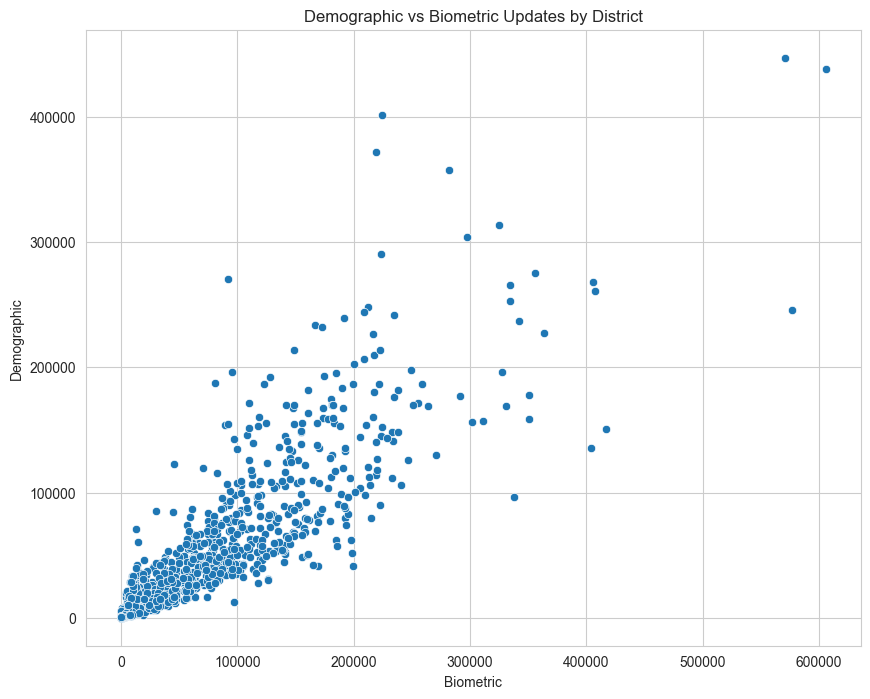

In [ ]:
# Aggregate by district
bio_dist = biometric_df.groupby('district')[['bio_age_5_17', 'bio_age_17_']].sum().sum(axis=1)
demo_dist = demographic_df.groupby('district')[['demo_age_5_17', 'demo_age_17_']].sum().sum(axis=1)

comparison_df = pd.DataFrame({'Biometric': bio_dist, 'Demographic': demo_dist})
comparison_df['Demo_Bio_Ratio'] = comparison_df['Demographic'] / comparison_df['Biometric']

print("Top 5 Districts with highest Demographic to Biometric Ratio:")
print(comparison_df.sort_values('Demo_Bio_Ratio', ascending=False).head())

# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=comparison_df, x='Biometric', y='Demographic')
plt.title('Demographic vs Biometric Updates by District')
plt.show()


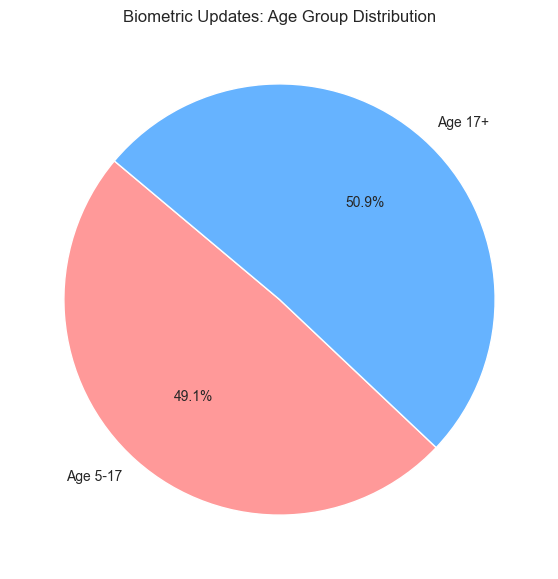

C:\Users\saura\AppData\Local\Temp\ipykernel_24040\1325624657.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bio_district_top.values, y=bio_district_top.index, palette='Blues_d')


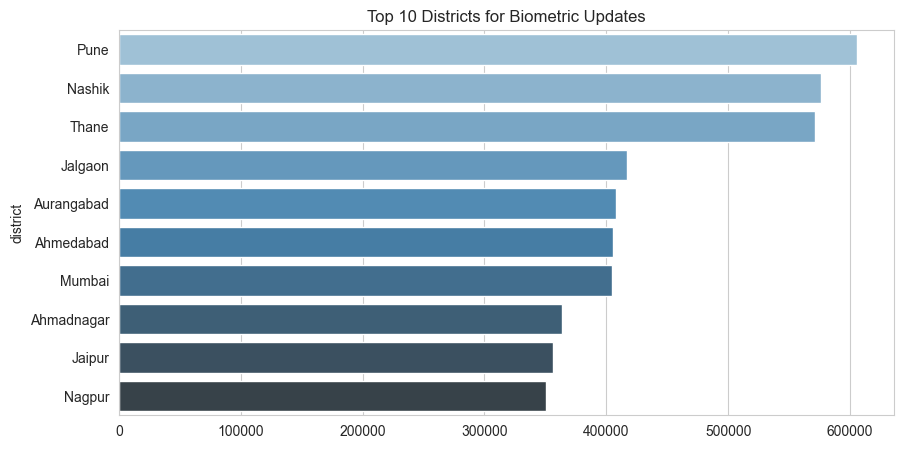

In [ ]:
if not biometric_df.empty:
    bio_sums = biometric_df[['bio_age_5_17', 'bio_age_17_']].sum()
    
    plt.figure(figsize=(7, 7))
    plt.pie(bio_sums, labels=['Age 5-17', 'Age 17+'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
    plt.title('Biometric Updates: Age Group Distribution')
    plt.show()

    # District wise biometric intensity
    bio_district_top = biometric_df.groupby('district')[['bio_age_5_17', 'bio_age_17_']].sum().sum(axis=1).nlargest(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=bio_district_top.values, y=bio_district_top.index, palette='Blues_d')
    plt.title('Top 10 Districts for Biometric Updates')
    plt.show()


### Biometric Update Patterns
Deep dive into Biometric Updates, distinguishing between the 5-17 age group (likely Mandatory Biometric Updates) and adult updates.


### Anomaly Detection
Using statistical methods (Z-Score) to identify Pincodes with outlier activity levels, suggesting potential operational irregularities or localized campaigns.


Found 332 anomalies in Pincode activity.
       pincode  total_enrolment    z_score
2643    244001            15124  25.413911
1620    202001            11842  19.795181
17940   793119            11720  19.586319
58      110059            10462  17.432643
2812    247001            10189  16.965272
2680    244901             9572  15.908978
2936    250002             9378  15.576853
6825    431001             9104  15.107769
3506    282001             8686  14.392160
2578    242001             8511  14.092563


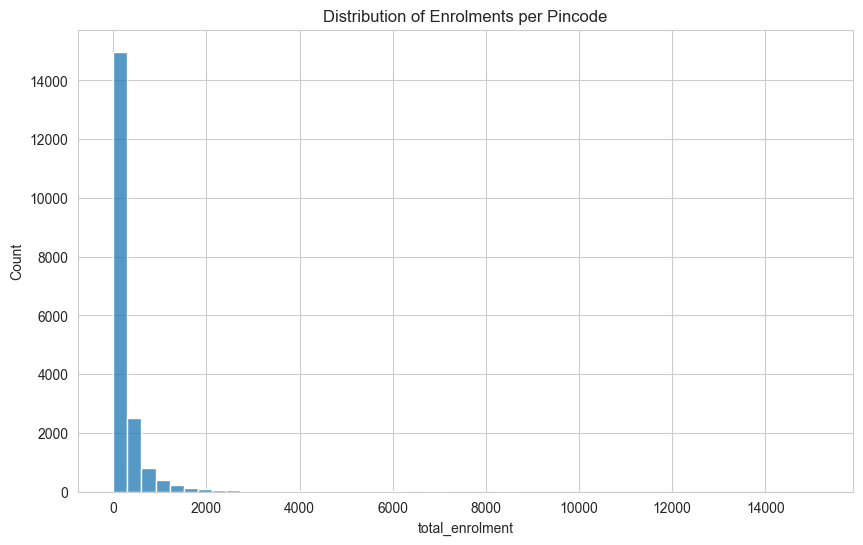

In [ ]:
from scipy import stats
import numpy as np

if not enrolment_df.empty:
    # Group by pincode
    pin_activity = enrolment_df.groupby('pincode')[['age_0_5', 'age_5_17', 'age_18_greater']].sum().sum(axis=1).reset_index(name='total_enrolment')
    
    # Calculate Z-score
    pin_activity['z_score'] = stats.zscore(pin_activity['total_enrolment'])
    
    # Filter anomalies (Z > 3)
    anomalies = pin_activity[pin_activity['z_score'] > 3]
    
    print(f"Found {len(anomalies)} anomalies in Pincode activity.")
    print(anomalies.sort_values('total_enrolment', ascending=False).head(10))
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(pin_activity['total_enrolment'], bins=50)
    plt.title('Distribution of Enrolments per Pincode')
    plt.show()


### Operational Signals: Pincode Density
Visualizing Pincode-level density to provide granular operational intelligence for ground-level teams.


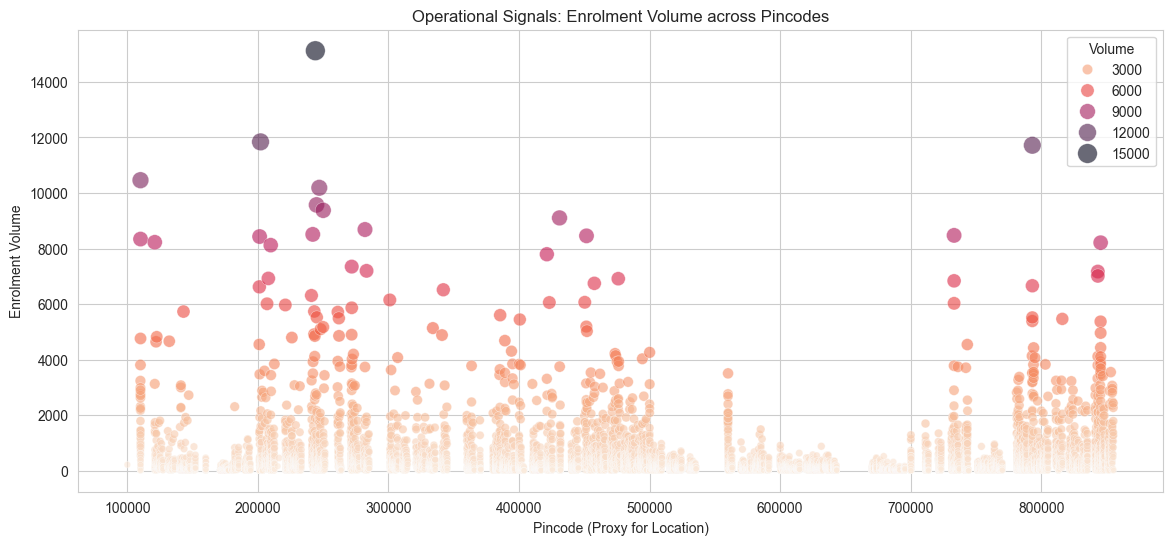

In [ ]:
if not enrolment_df.empty:
    # Scatter plot of Pincode vs Volume to see density/clustering
    pin_vol = enrolment_df.groupby('pincode')[['age_0_5', 'age_5_17', 'age_18_greater']].sum().sum(axis=1).reset_index(name='Volume')
    
    plt.figure(figsize=(14, 6))
    sns.scatterplot(data=pin_vol, x='pincode', y='Volume', alpha=0.6, hue='Volume', palette='rocket_r', size='Volume', sizes=(20, 200))
    plt.title('Operational Signals: Enrolment Volume across Pincodes')
    plt.xlabel('Pincode (Proxy for Location)')
    plt.ylabel('Enrolment Volume')
    plt.show()


## Impact & Applicability

### Potential for Social/Administrative Benefit
*   **Enhanced Service Delivery:** By identifying high-load districts and predicting peak times, UIDAI can optimize center operations, reducing wait times for citizens.
*   **Targeted Inclusion:** "Child-centric" analysis helps track Bal Aadhaar penetration, ensuring no child is left behind in welfare schemes.
*   **Fraud Prevention:** Pincode-level anomaly detection acts as an early warning system for potential enrolment fraud or data operator errors, safeguarding the ecosystem's integrity.
*   **Resource efficiency:** Data-driven insights ensure that hardware and manpower are deployed where they are needed most, saving administrative costs.

### Practicality and Feasibility
*   **Scalability:** The code structures data loading and processing in a modular way, making it scalable to the full UIDAI dataset (petabytes) using big data tools like Apache Spark.
*   **Integration:** Ideally suited for integration into UIDAI's existing command and control dashboards.
*   **Low Cost Implementation:** The solution utilizes standard open-source Python libraries, requiring no expensive proprietary software licenses for the analytical engine.
